In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

__Data Sourcing__

In [2]:
#Reading the data from csv file to dataframe
loan_data = pd.read_csv("loan.csv", low_memory=False)

__Data Cleaning__

In [3]:
#Check for unnecessary header and footer rows to delete
loan_data.head()
loan_data.tail()
print(loan_data.shape)
#Remove missing value columns if any
loan_data.dropna(axis = 1, how = 'all', inplace = True)
print(loan_data.shape)

(39717, 111)
(39717, 57)


<font color=blue>__None of the columns having all null values__</font>

<Axes: >

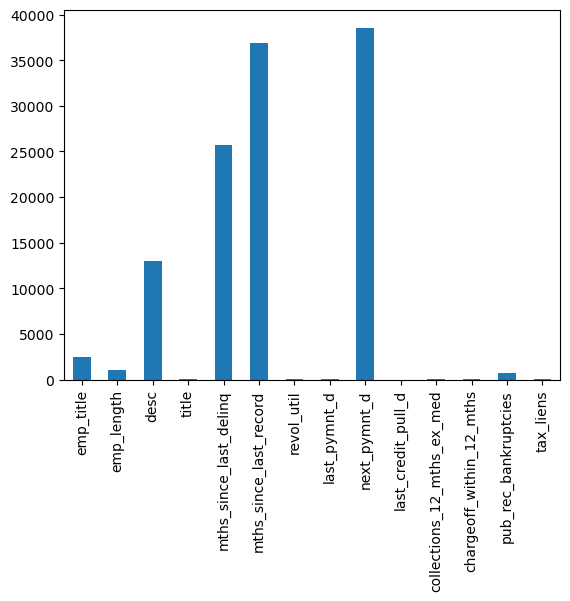

In [4]:
#plot to understand missing values in each column of the dataset
loan_data.isna().sum()[loan_data.isna().sum()>0].plot(kind='bar')

In [5]:
#From above plot we can see that some cloumns have missing values, drop columns where null values are more than 10000
loan_data.drop(loan_data.columns[loan_data.apply(lambda col: col.isna().sum() > 10000)], axis=1, inplace=True)
print(loan_data.shape)
#Remove missing value rows from columns having null vlaues <= 10000
loan_data.dropna(subset=loan_data.columns[loan_data.apply(lambda col: col.isna().sum() <= 10000)], inplace=True)
print(loan_data.shape)

(39717, 53)
(36431, 53)


In [6]:
#Drop columns with only one value for all rows . We can't do any analysis on these columns.
loan_data.drop(loan_data.columns[loan_data.apply(lambda col: col.nunique() == 1)], axis=1, inplace=True)
print(loan_data.shape)

(36431, 44)


In [7]:
#Let us understand the loan_data
print(loan_data.dtypes)

id                           int64
member_id                    int64
loan_amnt                    int64
funded_amnt                  int64
funded_amnt_inv            float64
term                        object
int_rate                    object
installment                float64
grade                       object
sub_grade                   object
emp_title                   object
emp_length                  object
home_ownership              object
annual_inc                 float64
verification_status         object
issue_d                     object
loan_status                 object
url                         object
purpose                     object
title                       object
zip_code                    object
addr_state                  object
dti                        float64
delinq_2yrs                  int64
earliest_cr_line            object
inq_last_6mths               int64
open_acc                     int64
pub_rec                      int64
revol_bal           

__Standardising Values__

In [8]:
#Remove % from int_rate and convert to float with two decimal places
loan_data['int_rate']=loan_data['int_rate'].apply(lambda x:str(x).replace('%','')).astype('float').round(2)
loan_data.head()
#Remove the duplicated rows if any
loan_data.drop_duplicates()
loan_data.shape

(36431, 44)

In [9]:
#id and member_id are unique values. Can't derive charged_off info from them. Let us drop these columns.
loan_data.drop(["id", "member_id"], axis = 1, inplace = True)      

In [10]:
loan_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,5632.21,5000.00,632.21,0.00,0.00,0.00,Jan-15,161.03,Jan-16,0.0
6,7000,7000,7000.0,60 months,15.96,170.08,C,C5,Southern Star Photography,8 years,...,10110.84,6985.61,3125.23,0.00,0.00,0.00,May-16,1313.76,May-16,0.0


In [11]:
#Drop grade & sub grade as these are assigned by LC. These are not customer characteristics that influence loan_status to default. Drop emp_title also, as this is random value.
loan_data.drop(["grade", "sub_grade","emp_title"], axis = 1, inplace = True)
loan_data.shape
#out_prncp & out_prncp_inv are for current applicant in the process of paying the installments.
# recoveries is post charge_off, total_rec_late_fee is late fees received
#These attributes can't influence the tendency of default. Let us drop these columns.
loan_data.drop(["out_prncp", "out_prncp_inv", "recoveries", "total_rec_late_fee"], axis = 1, inplace = True)
loan_data.shape

(36431, 35)

<Axes: >

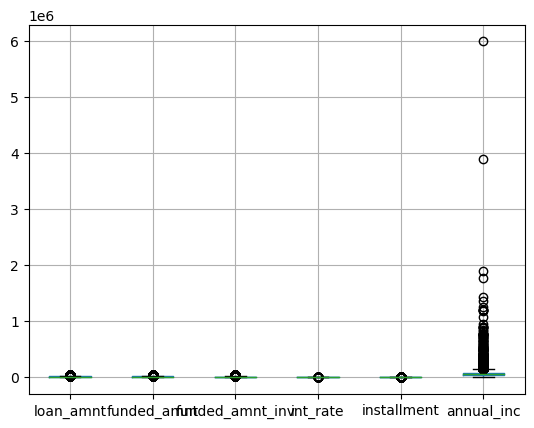

In [12]:
#Identify outliers
data_to_plot = loan_data[['loan_amnt', 'funded_amnt', 'funded_amnt_inv','int_rate', 'installment', 'annual_inc']]
data_to_plot.boxplot()

<font color=blue> __"annual_inc" has outliers. Let us deal with these outliers.Rest all looking like continuous data. No outliers.__ </font>

In [13]:
print(loan_data["annual_inc"].describe())

count    3.643100e+04
mean     6.930694e+04
std      6.354376e+04
min      4.000000e+03
25%      4.200000e+04
50%      6.000000e+04
75%      8.300000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64


(34482, 35)

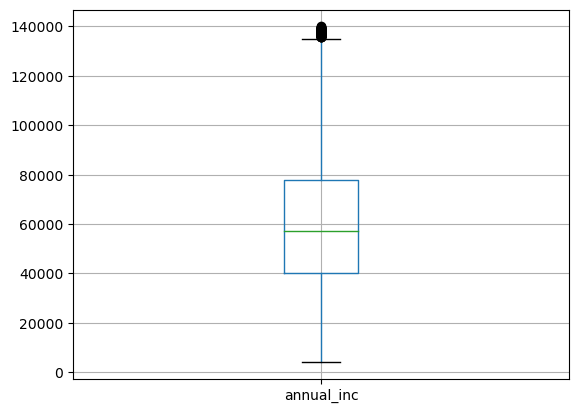

In [14]:
# Remove values greater than 95th percentile
loan_data = loan_data[loan_data["annual_inc"] < loan_data["annual_inc"].quantile(0.95)]
data_to_plot = loan_data[['annual_inc']]
data_to_plot.boxplot()
loan_data.shape

<font color=blue> __After removing values > 0.95 percentile "annual_inc" seems to have continuous data.__ </font>

<Axes: >

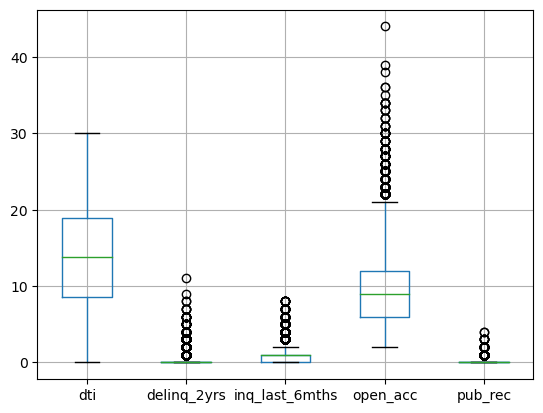

In [15]:
#Identify outliers
data_to_plot = loan_data[['dti', 'delinq_2yrs', 'inq_last_6mths','open_acc','pub_rec']]
data_to_plot.boxplot()

<font color=blue> __These parameters are important to analyze the customer tendency to default. Let us not remove any values.__ </font>

<Axes: >

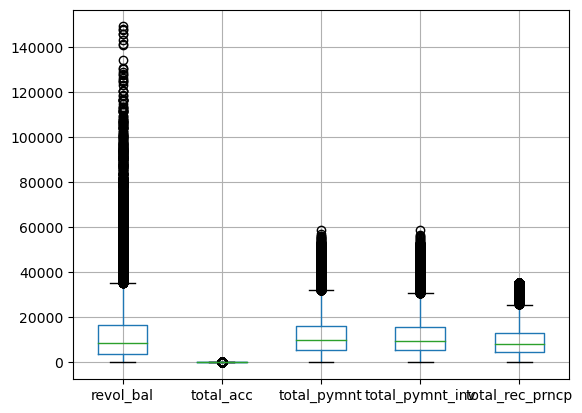

In [16]:
#Identify outliers
data_to_plot = loan_data[['revol_bal', 'total_acc','total_pymnt','total_pymnt_inv','total_rec_prncp']]
data_to_plot.boxplot()

<font color=blue> __No outliers.__ </font>

<Axes: >

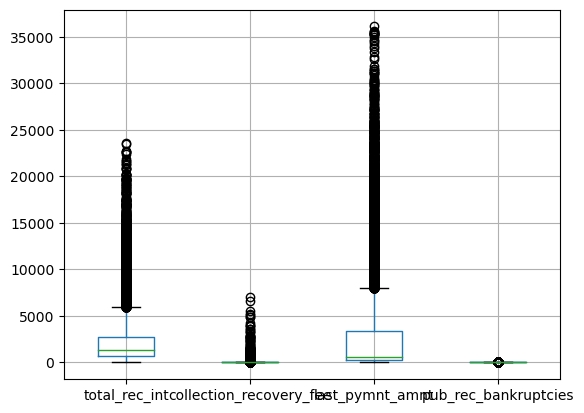

In [17]:
#Identify outliers
data_to_plot = loan_data[['total_rec_int','collection_recovery_fee','last_pymnt_amnt','pub_rec_bankruptcies']]
data_to_plot.boxplot()

<font color=blue> __No outliers.__ </font>

__Fix invalid values__

In [18]:
#emp_length < 1 year is considered as 0 and 10+ years is considered as 10 
loan_data["emp_length"] = pd.to_numeric(loan_data["emp_length"].apply(lambda x: x.replace('years','').replace('year','').replace('+','').replace('< 1','0')))
loan_data["emp_length"].value_counts()

10    7788
2     3985
0     3883
3     3716
4     3143
5     2968
1     2897
6     2027
7     1625
8     1312
9     1138
Name: emp_length, dtype: int64

__Univariate Analysis__

 36 months    72.7162
 60 months    27.2838
Name: term, dtype: float64

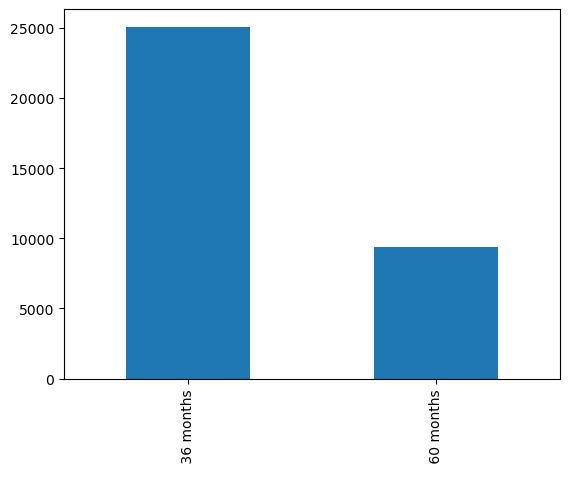

In [19]:
#From data dictionary we see the term as the number of payments on the loan. Values are in months and can be either 36 or 60. 
#Convert this to a categorical variable 
loan_data['term'] = loan_data['term'].astype('category')
loan_data['term'].value_counts().plot.bar()
(loan_data['term'].value_counts()*100)/len(loan_data)

<font color=blue> __73% applicants are with loan term of 36months__ </font>

Fully Paid     83.394235
Charged Off    13.763703
Current         2.842063
Name: loan_status, dtype: float64

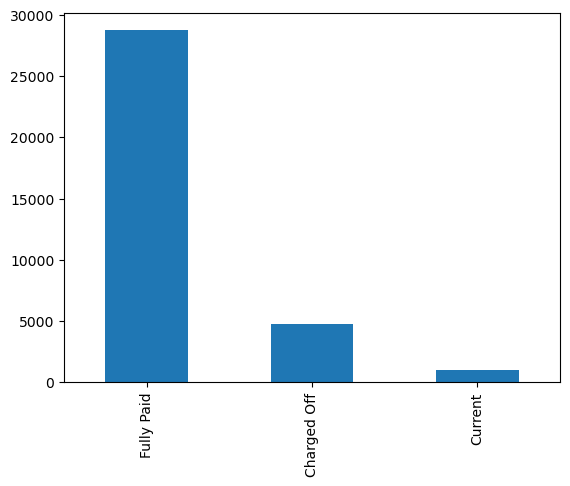

In [20]:
#From problem statement we know the loan_status can be fully paid, charged_off or current. 
#Convert this to a categorical variable 
loan_data['loan_status'] = loan_data['loan_status'].astype('category')
loan_data['loan_status'].value_counts().plot.bar()
(loan_data['loan_status'].value_counts()*100)/len(loan_data)

<font color=blue> __Around 14% of loan applicants are charged_off__ </font>

RENT        49.280784
MORTGAGE    43.286352
OWN          7.177658
OTHER        0.255206
Name: home_ownership, dtype: float64

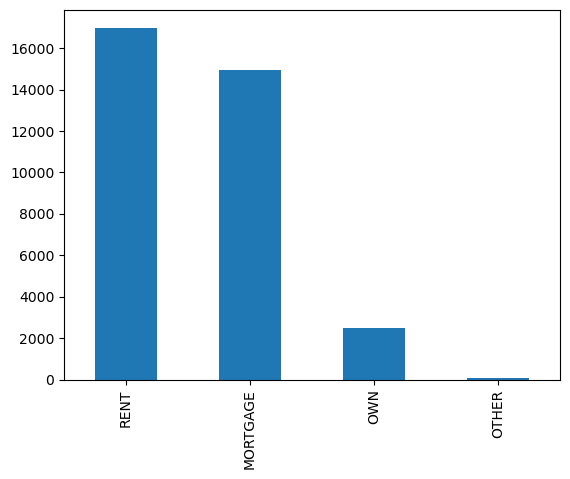

In [21]:
#Convert home_ownership to categorical variable
loan_data['home_ownership']=loan_data['home_ownership'].astype('category')
loan_data['home_ownership'].value_counts().plot.bar()
(loan_data['home_ownership'].value_counts()*100)/len(loan_data)

<font color=blue> __Around 49% of loan applicants are having rental accomodation followed by 43% are mortgage__ </font>

debt_consolidation    48.361464
credit_card           12.969085
other                  9.880517
home_improvement       6.939853
major_purchase         5.510121
car                    4.045589
small_business         3.799084
wedding                2.462154
medical                1.722638
moving                 1.450032
vacation               0.942521
house                  0.916420
educational            0.768517
renewable_energy       0.232005
Name: purpose, dtype: float64

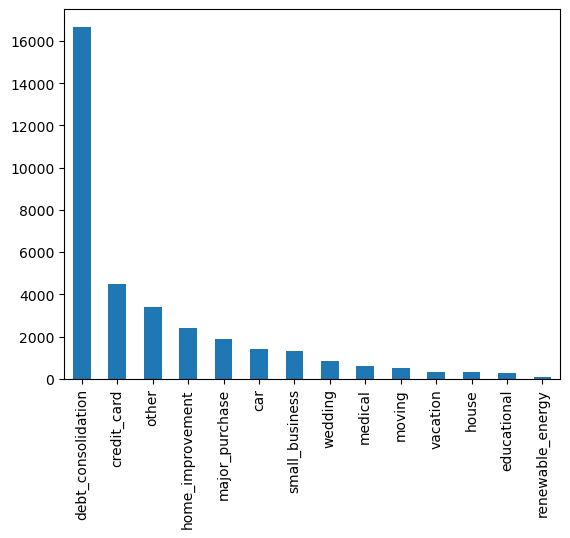

In [22]:
#From problem statement we know the purpose can be converted to categorical variable
loan_data['purpose']=loan_data['purpose'].astype('category')
loan_data['purpose'].value_counts().plot.bar()
(loan_data['purpose'].value_counts()*100)/len(loan_data)

<font color=blue> __Around 48% of loan applicants have mentioned purpose as debt_consolidation followed by 13% credit card__ </font>

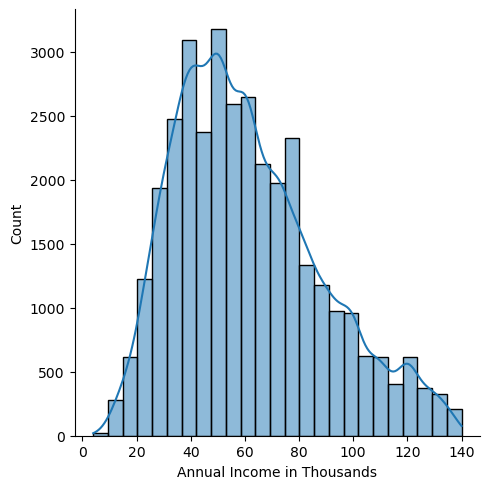

In [23]:
# Understanding how annual_inc is distributed
sns.displot(loan_data.annual_inc/1000,bins=25,kde=True)
plt.xlabel('Annual Income in Thousands')
plt.show()

<font color=blue>__Majority of loan applicants have annual_income between 30K to 80K__</font>

__Bivariate Analysis__

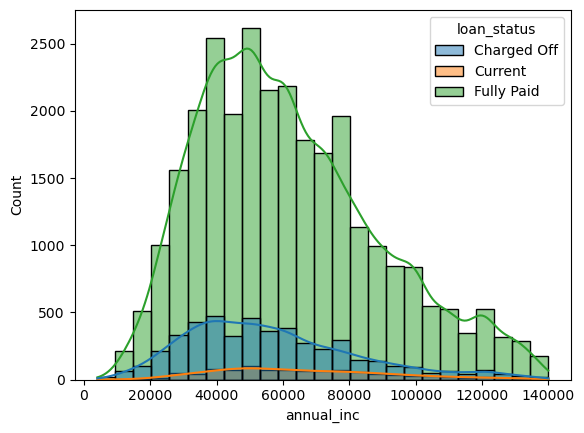

In [24]:
# Our aim is to identify the risky loan applicants i.e. loan_status as charged_off . Let us see how other factors are influencing this.
sns.histplot(data=loan_data, x= 'annual_inc', hue='loan_status',bins=25, kde=True)
plt.show()

<font color=blue>__Loan applicants with annual income 20k to 80k have more defaults and annual income greater than 120k charged_off count is coming down significantly .__</font>

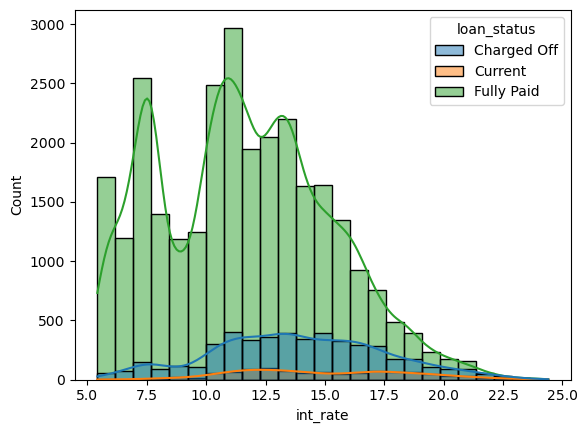

In [25]:
sns.histplot(data=loan_data, x= 'int_rate', hue='loan_status',bins=25, kde=True)
plt.show()

<font color=blue>__Defaulters are spread almost linearly across 10% to 20% interest rate. We see less defaulters at low interest rate < 10% or high interest rate > 20%__</font>

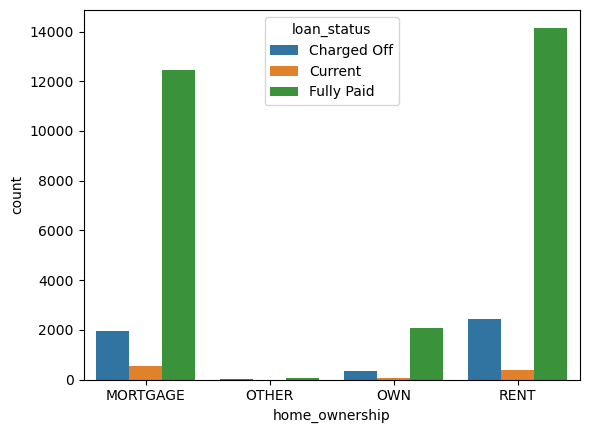

In [26]:
sns.countplot(data=loan_data,x='home_ownership',hue='loan_status')
plt.show()

<font color=blue>__People with own houses are preferable for lending loans__</font>

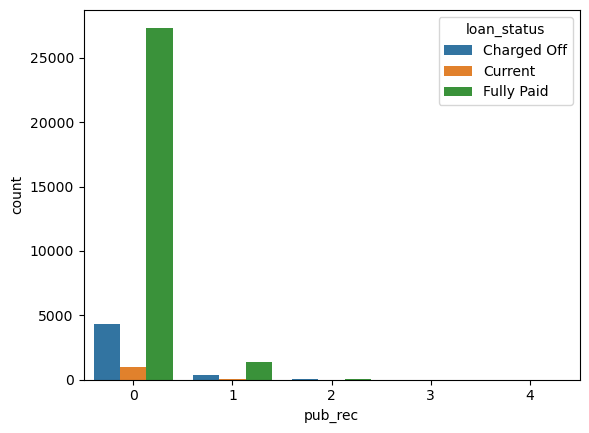

In [41]:
sns.countplot(data=loan_data,x='pub_rec',hue='loan_status')
plt.show()


<font color=blue>__Not able to derive any useful info related to defaulters from the above graph.__</font>